# Posterior Predictive Checks (PPC) in SBI

A common **safety check** performed as part of inference are [Posterior Predictive Checks (PPC)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssa.12378). A PPC compares data $x_{\text{pp}}$ generated using the parameters $\theta_{\text{posterior}}$ sampled from the posterior with the observed data $x_o$. The general concept is that -if the inference is correct- **the generated data $x_{\text{pp}}$ should "look like" the oberved data $x_0$**. Said differently, $x_o$ should be within the support of $x_{\text{pp}}$.

A PPC usually shouldn't be used as a [validation metric](http://proceedings.mlr.press/v130/lueckmann21a.html). Nonetheless a PPC is a good start for an inference diagnosis and can provide with an intuition about any bias introduced in inference: does $x_{\text{pp}}$ systematically differ from $x_o$?

## Main syntax

```python
from sbi.analysis import pairplot

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
posterior_samples = posterior.sample((5_000,))

# We use posterior theta samples to generate x data
x_pp = simulator(posterior_samples)

# We verify if the observed data falls within the support of the generated data
_ = pairplot(
    samples=x_pp,
    points=x_o
)
```

## Performing a PPC over a toy example

Below we provide an example Posterior Predictive Check (PPC) over some toy example:

In [1]:
from sbi.analysis import pairplot
import torch

_ = torch.manual_seed(0)

We work on an inference problem over three parameters using ani of the techniques implemented in `sbi`. In this tutorial, we load the dummy posterior:

In [2]:
from toy_posterior_for_07_cc import ExamplePosterior
posterior = ExamplePosterior()

Let us say that we are observing the data point $x_o$:

In [3]:
D = 5  # simulator output was 5-dimensional
x_o = torch.ones(1, D)
posterior.set_default_x(x_o)

The posterior can be used to draw $\theta_{\text{posterior}}$ samples:

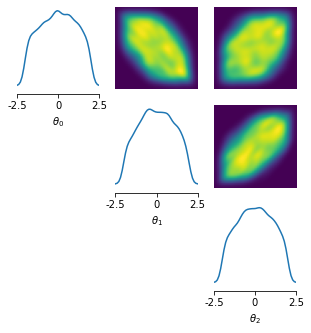

In [4]:
posterior_samples = posterior.sample((5000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.5, 2.5]]*3),
    upper=['kde'],
    diag=['kde'],
    figsize=(5,5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

Now we can use our simulator to generate some data $x_{\text{PP}}$, using as input parameters the poterior samples $\theta_{\text{posterior}}$. Note that the simulation part is not in the `sbi` scope, so any simulator -including a non-Python one- can be used at this stage. In our case we'll use a dummy simulator:

In [5]:
def dummy_simulator(
    posterior_samples: torch.Tensor,
    *args,
    **kwargs
) -> torch.Tensor:
    sample_size = posterior_samples.shape[0]
    scale = 1.0

    shift = torch.distributions.Gumbel(
        loc=torch.zeros(D),
        scale=scale / 2
    ).sample()
    return torch.distributions.Gumbel(
        loc=x_o[0] + shift,
        scale=scale
    ).sample((sample_size,))

x_pp = dummy_simulator(posterior_samples)


Plotting $x_o$ against the $x_{\text{pp}}$, we perform a PPC that plays the role of a sanity check. In this case, the check indicates that $x_o$ falls right within the support of $x_{\text{pp}}$, which should make the experimenter rather confident about the estimated `posterior`:

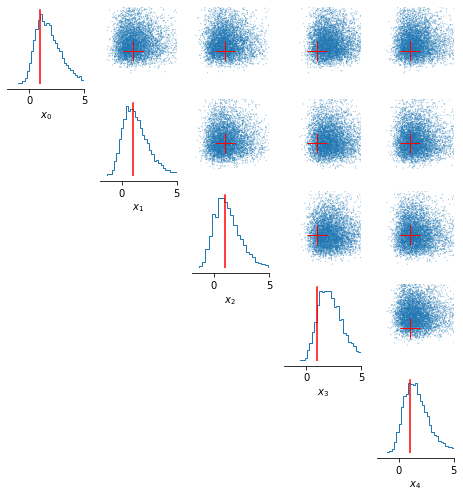

In [6]:
_ = pairplot(
    samples=x_pp,
    points=x_o[0],
    limits=torch.tensor([[-2., 5.]]*5),
    points_colors="red",
    figsize=(8,8),
    upper="scatter",
    scatter_offdiag=dict(
        marker='.',
        s=5
    ),
    points_offdiag=dict(
        marker='+',
        markersize=20
    ),
    labels=[rf"$x_{d}$" for d in range(D)]
)

In contrast, $x_o$ falling well outside the support of $x_{\text{pp}}$ is indicative of a failure to estimate the correct posterior. Here we simulate such a failure mode:

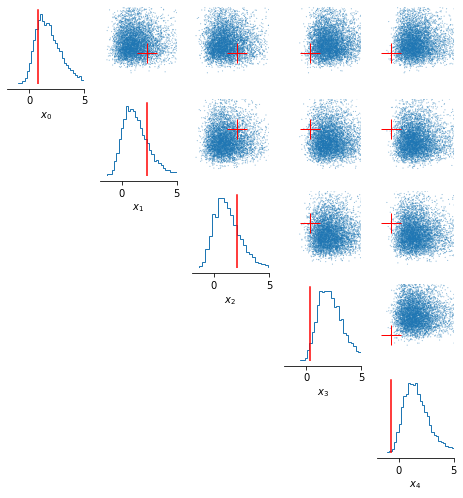

In [7]:
error_shift = torch.distributions.Normal(
    loc=torch.zeros(D),
    scale=2.0 * torch.ones(D)
).sample()

_ = pairplot(
    samples=x_pp,
    points=x_o[0] + error_shift,
    limits=torch.tensor([[-2., 5.]]*5),
    points_colors="red",
    figsize=(8,8),
    upper="scatter",
    scatter_offdiag=dict(
        marker='.',
        s=5
    ),
    points_offdiag=dict(
        marker='+',
        markersize=20
    ),
    labels=[rf"$x_{d}$" for d in range(D)]
)

A typical way to investigate this issue would be to run a ***prior* predictive check**, applying the same plotting strategy, but drawing $\theta$ from the prior instead of the posterior. **The support for $x_{\text{pp}}$ should be larger and should contain $x_o$**. I fthis check is successful, the "blame" can then be shifted to the inference (method used, convergence of density estimators, number of sequential rounds, etc...).